# Understanding Hierarchical Actor-Critic (HAC): A Complete Guide

### Important Note:

It contains some `bugs` and is not fully functional. The code is provided for educational purposes and may require modifications to work correctly. The focus is on the conceptual understanding of HAC and its implementation in a custom multi-goal grid world environment.

# Table of Contents

- [Introduction: Hierarchy in Reinforcement Learning](#introduction)
- [What is HAC?](#what-is-hac)
  - [Core Idea: Levels of Abstraction & Goal Setting](#core-idea)
  - [Key Mechanisms: Time Limits, Intrinsic Rewards, Hindsight](#key-mechanisms)
- [Why Hierarchical RL? Advantages](#why-hrl)
- [Where and How HAC is Used](#where-and-how-hac-is-used)
- [Mathematical Foundation of HAC (Conceptual)](#mathematical-foundation-of-hac)
  - [Multi-Level Policies & Value Functions](#multi-level-policies--value-functions)
  - [Goal-Conditioned Learning](#goal-conditioned-learning)
  - [Intrinsic Motivation (Subgoal Achievement)](#intrinsic-motivation)
  - [Hindsight Goal Transitions](#hindsight-goal-transitions)
  - [Underlying Off-Policy Algorithm (e.g., DDPG/TD3/SAC adapted)](#underlying-off-policy-algorithm)
- [Step-by-Step Explanation of HAC (2-Level Example)](#step-by-step-explanation-of-hac)
- [Key Components of HAC](#key-components-of-hac)
  - [Hierarchical Layers/Levels](#hierarchical-layerslevels)
  - [Goal Representation](#goal-representation)
  - [Goal-Conditioned Networks (Actor/Critic or Q-Network)](#goal-conditioned-networks)
  - [Time Limit per Level ($H$)](#time-limit-per-level-h)
  - [Subgoal Testing](#subgoal-testing)
  - [Intrinsic Reward Mechanism](#intrinsic-reward-mechanism)
  - [Hindsight Goal/Transition Strategy](#hindsight-goaltransition-strategy)
  - [Replay Buffers (Per Level)](#replay-buffers-per-level)
  - [Hyperparameters](#hyperparameters)
- [Practical Example: Custom Multi-Goal Grid World](#practical-example-custom-multi-goal-grid-world)
  - [Environment Design Rationale for HAC](#environment-design-rationale-for-hac)
- [Setting up the Environment](#setting-up-the-environment)
- [Creating the Custom Grid Environment](#creating-the-custom-grid-environment)
- [Implementing the HAC Algorithm](#implementing-the-hac-algorithm)
  - [Goal/State Representation](#goalstate-representation)
  - [Defining the Low-Level Agent Network (Goal-Conditioned DQN-like)](#defining-the-low-level-agent-network)
  - [Defining the High-Level Agent Network (Goal-Selecting DQN-like)](#defining-the-high-level-agent-network)
  - [Defining the Hindsight Replay Buffer](#defining-the-hindsight-replay-buffer)
  - [Soft Update Function](#soft-update-function)
  - [The HAC Controller/Agent Structure](#the-hac-controlleragent-structure)
    - [Low-Level Action Selection & Training](#low-level-action-selection--training)
    - [High-Level Goal Selection & Training](#high-level-goal-selection--training)
    - [Hindsight Transition Generation](#hindsight-transition-generation)
- [Running the HAC Algorithm](#running-the-hac-algorithm)
  - [Hyperparameter Setup](#hyperparameter-setup)
  - [Initialization](#initialization)
  - [Training Loop](#training-loop)
- [Visualizing the Learning Process](#visualizing-the-learning-process)
- [Analyzing the Learned Policies (Testing)](#analyzing-the-learned-policies-testing)
- [Common Challenges and Extensions of HAC](#common-challenges-and-extensions-of-hac)
- [Conclusion](#conclusion)

## Introduction: Hierarchy in Reinforcement Learning

Many real-world tasks exhibit a natural hierarchical structure. Solving complex problems often involves breaking them down into simpler sub-tasks or achieving intermediate goals. Hierarchical Reinforcement Learning (HRL) aims to leverage this structure by learning policies at multiple levels of temporal abstraction. Higher levels learn to set goals or sequences of sub-tasks, while lower levels learn to execute primitive actions to achieve those goals.

## What is HAC?

Hierarchical Actor-Critic (HAC), introduced by Levy et al. (2019), is a specific HRL algorithm that uses goal-conditioned policies operating at different time scales. It is designed to handle complex tasks with sparse rewards by allowing higher levels to set achievable subgoals for lower levels.

### Core Idea: Levels of Abstraction & Goal Setting
Imagine a multi-layered control system:
- **High Level:** Observes the overall state and chooses a *subgoal* (e.g., a desired state configuration) to achieve within a relatively long time horizon.
- **Low Level:** Receives the current state and the subgoal from the higher level. It then selects *primitive actions* to try and reach that subgoal within a shorter time limit.

Each level acts like an RL agent, learning its own policy (actor) and value function (critic, or Q-function). The 'actions' for higher levels are the subgoals they set for the level below.

### Key Mechanisms: Time Limits, Intrinsic Rewards, Hindsight
HAC incorporates several key ideas:
1.  **Fixed Time Limits ($H$):** Each level (except the lowest) gives the level below it a fixed number of primitive timesteps ($H$) to achieve the assigned subgoal.
2.  **Goal-Conditioned Learning:** Policies and value functions at each level are conditioned not only on the state but also on the goal they are trying to achieve. $Q(state, action, goal)$ or $\pi(action | state, goal)$.
3.  **Intrinsic Motivation:** The lower level receives an intrinsic reward (e.g., +1 or 0) if it successfully reaches the subgoal assigned by the higher level within the time limit, and a penalty (e.g., -1) otherwise. This reward guides the lower level's learning.
4.  **Hindsight Goal Transitions (HER-like):** To combat the sparsity of intrinsic rewards (reaching the *exact* subgoal might be rare initially), HAC uses hindsight. Even if the lower level failed to reach the *intended* goal, it reached *some* final state. HAC stores transitions in the replay buffer as if this *achieved* final state was the *intended* goal. This creates artificial success examples, dramatically improving sample efficiency for goal-conditioned learning.
5.  **Off-Policy Learning:** Because of the hindsight relabeling, the underlying RL algorithm used at each level must be off-policy (like DDPG, TD3, SAC, or adapted DQN/DDQN) to learn from these modified transitions.

## Why Hierarchical RL? Advantages

- **Long Horizon Tasks:** HRL decomposes long, complex tasks into manageable sub-problems, making learning feasible where standard RL might fail due to sparse rewards or credit assignment issues.
- **Structured Exploration:** Higher levels can guide exploration more effectively by setting diverse subgoals, rather than relying solely on random exploration in the primitive action space.
- **Transfer and Reusability:** Lower-level policies trained to achieve specific subgoals might be reusable across different high-level tasks.
- **Improved Sample Efficiency:** Hindsight mechanisms can significantly speed up learning in goal-conditioned tasks.

## Where and How HAC is Used

HAC and similar HRL approaches are applied to:
1.  **Robotics:** Complex manipulation tasks (e.g., stacking blocks, opening doors), locomotion over obstacles.
2.  **Navigation:** Long-range navigation in complex environments (e.g., mazes with keys and doors).
3.  **Game Playing:** Strategy games requiring long-term planning.

## Mathematical Foundation of HAC (Conceptual)

Let's consider a 2-level hierarchy (Level 0: primitive actions, Level 1: sets subgoals for Level 0).

### Multi-Level Policies & Value Functions
- **Level 0 (Low):** Learns policy $\pi_0(a_t | s_t, g_0)$ and value function $Q_0(s_t, a_t, g_0)$. It receives state $s_t$ and a subgoal $g_0$ (set by Level 1) and outputs primitive action $a_t$.
- **Level 1 (High):** Learns policy $\pi_1(g_0 | s_t, G)$ and value function $Q_1(s_t, g_0, G)$. It receives state $s_t$ and the overall task goal $G$ and outputs a subgoal $g_0$ for Level 0.

### Goal-Conditioned Learning
The inputs to the networks explicitly include the goal the level is trying to achieve. This is often done by concatenating the state representation with the goal representation.

### Intrinsic Motivation (Subgoal Achievement)
Level 0 is trained to maximize an intrinsic reward signal based on achieving $g_0$. A simple binary reward:
$$ R_{intrinsic}(s_{t+H}, g_0) = \begin{cases} 0 & \text{if } \text{test_goal}(s_{t+H}, g_0) \text{ is True} \\ -1 & \text{otherwise} \end{cases} $$
where `test_goal` checks if the state reached after $H$ steps satisfies the subgoal $g_0$ (e.g., distance below a threshold).

### Hindsight Goal Transitions
When storing a transition sequence $(s_t, ..., s_{t+H})$ taken by Level 0 aiming for goal $g_0$:
1.  Store the original transition with the original goal $g_0$ and the calculated intrinsic reward $R_{intrinsic}(s_{t+H}, g_0)$.
2.  Store an *additional* hindsight transition: Use the *achieved* state $s_{t+H}$ as the hindsight goal $g'_{0} = s_{t+H}$. The intrinsic reward for this transition is always the success reward (e.g., 0), as the achieved state *is* the goal by definition.
This allows Level 0 to learn how to reach states it happened to land in, even if they weren't the original target.

### Underlying Off-Policy Algorithm (e.g., DDPG/TD3/SAC adapted)
Each level uses an off-policy algorithm to learn its goal-conditioned policy and/or value function from transitions (original and hindsight) stored in its replay buffer. For discrete actions (like our Grid World low level), an adapted DQN/DDQN can be used. For continuous actions/goals (original HAC), DDPG/TD3 is common.

The update involves sampling a batch of goal-conditioned transitions $(s, a, r, s', g)$ and performing the corresponding off-policy update (e.g., Bellman error minimization for Q-learning/critic, policy gradient for actor).

## Step-by-Step Explanation of HAC (2-Level Example)

1.  **Initialize**: Networks $Q_0, Q'_0, Q_1, Q'_1$ (or Actor/Critics), replay buffers $D_0, D_1$. Hyperparameters $H$ (time limit), learning rates, etc.
2.  **Loop for each episode**:
    a.  Call Level 1 to select a subgoal $g_0$ for the overall goal $G$ based on initial state $s_0$. `subgoal = Level1.select_goal(s_0, G)`.
    b.  **Loop (Low-Level Execution)** for $h = 1$ to $H$:
        i.   Call Level 0 to select primitive action $a_t$ based on current state $s_t$ and subgoal $g_0$. `action = Level0.select_action(s_t, g_0)`.
        ii.  Execute $a_t$, observe $r_t, s_{t+1}$.
        iii. Store $(s_t, a_t, r_t, s_{t+1})$ temporarily for the current subgoal attempt.
        iv.  If $s_{t+1}$ achieves subgoal $g_0$ (`test_goal(s_{t+1}, g_0)`), break low-level loop.
        v.   If episode terminates based on environment `done` flag, handle episode end.
        vi.  $s_t \leftarrow s_{t+1}$.
    c.  **End of Subgoal Attempt**: Let the sequence be $s_{start}, a_{start}, ..., s_{end}$.
    d.  **Store Transitions with Hindsight**: 
        - For Level 0 buffer $D_0$: Store original transitions $(s_k, a_k, r_{intrinsic}, s_{k+1}, g_0)$ where $r_{intrinsic}$ depends on whether $s_{end}$ achieved $g_0$. Also store hindsight transitions $(s_k, a_k, 0, s_{k+1}, s_{end})$ (using $s_{end}$ as the achieved goal).
        - For Level 1 buffer $D_1$: Store the high-level transition $(s_{start}, g_0, R_{high}, s_{end}, G)$ where $R_{high}$ is the sum of environment rewards during the subgoal attempt.
    e.  **Perform Updates**: Sample batches from $D_0, D_1$ and update $Q_0, Q_1$ (and target networks) using the underlying off-policy algorithm.
    f.  If the overall goal $G$ is achieved, or max episode steps reached, end episode.
3.  **Repeat**.

## Key Components of HAC

### Hierarchical Layers/Levels
- Multiple policies operating at different temporal abstractions.

### Goal Representation
- How subgoals are defined (e.g., target state, change in state).

### Goal-Conditioned Networks
- Actors/Critics/Q-Networks take state *and* goal as input.

### Time Limit per Level ($H$)
- Maximum steps allocated for a lower level to achieve a subgoal.

### Subgoal Testing
- Function to determine if a state satisfies a given subgoal.

### Intrinsic Reward Mechanism
- How lower levels are rewarded for achieving assigned subgoals.

### Hindsight Goal/Transition Strategy
- Relabeling transitions with achieved goals to improve learning efficiency.

### Replay Buffers (Per Level)
- Store goal-conditioned transitions, including original and hindsight goals.

### Hyperparameters
- Number of levels, time limits $H$ per level.
- Underlying RL algorithm hyperparameters (learning rates, $\tau$, $\gamma$, buffer/batch sizes).
- Subgoal testing tolerance.
- Hindsight strategy parameters.

## Practical Example: Custom Multi-Goal Grid World

### Environment Design Rationale for HAC
Using the Grid World allows us to clearly define:
- **Goals:** Target `(row, col)` tuples.
- **Goal Testing:** Exact match `state == goal`.
- **State/Goal Concatenation:** Easily combine state `(r, c)` and goal `(gr, gc)` as input `(r, c, gr, gc)` to networks.
- **Underlying Algorithm:** Adapt DQN/DDQN for the discrete actions at the lower level and for goal selection at the higher level.

**Environment:** Standard 10x10 grid world. Final goal $G=(9,9)$.
- **Level 1 (High):** Observes state `(r, c)`, selects subgoal $g_0=(gr_0, gc_0)$ from possible grid cells. Aims to reach final goal $G$. Receives environment reward.
- **Level 0 (Low):** Observes state `(r, c)`, receives subgoal $g_0=(gr_0, gc_0)$. Selects primitive actions (U,D,L,R) to reach $g_0$ within $H$ steps. Receives intrinsic reward (-1 or 0).

**Note:** This is a simplified HAC structure. The original paper used DDPG as the base and continuous states/actions.

# Setting up the Environment

Import libraries.

In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import random
import math
from collections import namedtuple, deque, defaultdict
from itertools import count
from typing import List, Tuple, Dict, Optional, Callable, Any, Union
import copy

# Import PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set random seeds
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

%matplotlib inline

Using device: cpu


# Creating the Custom Grid Environment

Using the tabular version, suitable for discrete states/goals.

In [2]:
class GridEnvironmentTabular:
    """
    Grid World returning state tuples, suitable for tabular methods.
    Rewards: +10 (goal), -1 (wall), -0.1 (step).
    """
    def __init__(self, rows: int = 10, cols: int = 10) -> None:
        self.rows: int = rows
        self.cols: int = cols
        self.start_state: Tuple[int, int] = (0, 0)
        self.goal_state: Tuple[int, int] = (rows - 1, cols - 1)
        self.state: Tuple[int, int] = self.start_state
        self.action_dim: int = 4
        self.action_map: Dict[int, Tuple[int, int]] = {0: (-1, 0), 1: (1, 0), 2: (0, -1), 3: (0, 1)}

    def reset(self) -> Tuple[int, int]:
        """ Resets environment, returns state tuple. """
        self.state = self.start_state
        return self.state

    def step(self, action: int) -> Tuple[Tuple[int, int], float, bool]:
        """
        Performs one step, returns (next_state_tuple, reward, done).
        """
        if self.state == self.goal_state:
            return self.state, 0.0, True
        
        dr, dc = self.action_map[action]
        current_row, current_col = self.state
        next_row, next_col = current_row + dr, current_col + dc
        
        reward: float = -0.1
        if not (0 <= next_row < self.rows and 0 <= next_col < self.cols):
            next_row, next_col = current_row, current_col # Stay in place
            reward = -1.0
            
        self.state = (next_row, next_col)
        next_state_tuple = self.state
        
        done: bool = (self.state == self.goal_state)
        if done:
            reward = 10.0
            
        return next_state_tuple, reward, done

    def get_action_space_size(self) -> int:
        return self.action_dim
    
    def get_state(self) -> Tuple[int, int]:
        """ Returns the current state. """
        return self.state
    
    # Add this method to GridEnvironmentTabular class
    def is_terminal(self, state: Tuple[int, int]) -> bool:
        """ Checks if the state is terminal (goal state). """
        return state == self.goal_state
        

In [3]:
class GridEnvironmentHAC(GridEnvironmentTabular):
    """ Grid world adapted slightly for HAC state/goal use. """
    def __init__(self, rows: int = 10, cols: int = 10):
        super().__init__(rows=rows, cols=cols)
        # State representation for networks will be normalized
        self.state_dim = 2 # (r, c)
        self.goal_dim = 2 # (gr, gc)
        self.max_coord_float = float(max(rows - 1, cols - 1, 1)) # For normalization

    def _normalize_state_goal(self, state_or_goal: Tuple[int, int]) -> np.ndarray:
        """ Normalizes a state or goal tuple to range [0, 1]. """
        return np.array(state_or_goal, dtype=np.float32) / self.max_coord_float

    def get_normalized_state(self) -> np.ndarray:
        """ Returns the current state, normalized. """
        return self._normalize_state_goal(self.get_state())
    
    # Inherits reset(), step(), is_terminal(), get_possible_actions(), etc.
    # MCTS is not needed, HAC uses learned policies/Q-functions

Instantiate the environment.

In [4]:
hac_env = GridEnvironmentHAC(rows=10, cols=10)
state_dim_hac = hac_env.state_dim
goal_dim_hac = hac_env.goal_dim 
action_dim_hac = hac_env.get_action_space_size()
final_goal_state = hac_env.goal_state # The overall task goal
final_goal_norm = hac_env._normalize_state_goal(final_goal_state)

print(f"HAC Grid Environment: {hac_env.rows}x{hac_env.cols}")
print(f"State Dim: {state_dim_hac}, Goal Dim: {goal_dim_hac}, Action Dim: {action_dim_hac}")
print(f"Final Goal (raw): {final_goal_state}, Final Goal (norm): {final_goal_norm}")

HAC Grid Environment: 10x10
State Dim: 2, Goal Dim: 2, Action Dim: 4
Final Goal (raw): (9, 9), Final Goal (norm): [1. 1.]


# Implementing the HAC Algorithm

We need goal-conditioned networks, a hindsight replay buffer, and the hierarchical control logic.

### Goal/State Representation
Networks will take concatenated `(state, goal)` as input. We'll use normalized coordinates.

### Defining the Low-Level Agent Network (Goal-Conditioned DQN-like)

Takes `(state, goal)` and outputs Q-values for primitive actions.

In [5]:
class GoalConditionedQNetwork(nn.Module):
    """ Outputs Q(state, action | goal). Used for both levels. """
    def __init__(self, input_dim: int, action_dim: int):
        # input_dim = state_dim + goal_dim 
        super(GoalConditionedQNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_dim) # Q-value per action

    def forward(self, state_goal_concat: torch.Tensor) -> torch.Tensor:
        """ Maps concatenated (state, goal) to Q-values. """
        x = F.relu(self.fc1(state_goal_concat))
        x = F.relu(self.fc2(x))
        q_values = self.fc3(x)
        return q_values

### Defining the High-Level Agent Network (Goal-Selecting DQN-like)

For simplicity, we treat the high level's "action" (selecting a subgoal) as choosing from a discrete set of possible subgoals (e.g., all possible grid cells). This allows using a similar Q-network structure. A more complex approach for continuous goals would use DDPG-like actor/critic. 

*Note: This discretization of the high-level action space is a simplification.*

In [6]:
# The high level selects a goal (state tuple) as its action.
# We need a mapping from action index to goal state tuple.
all_possible_goals = [(r, c) for r in range(hac_env.rows) for c in range(hac_env.cols)]
num_possible_goals = len(all_possible_goals)
action_to_goal_map = {i: goal for i, goal in enumerate(all_possible_goals)}
goal_to_action_map = {goal: i for i, goal in enumerate(all_possible_goals)}

print(f"High level has {num_possible_goals} possible actions (goals).")

# High level uses the same Q-network structure, but output size is num_possible_goals
# Input dim = state_dim + final_goal_dim (which is also state_dim)
high_level_input_dim = state_dim_hac + goal_dim_hac
high_level_action_dim = num_possible_goals

HighLevelQNetwork = GoalConditionedQNetwork # Reuse the class structure

High level has 100 possible actions (goals).


### Defining the Hindsight Replay Buffer

Stores goal-conditioned transitions and handles hindsight relabeling.

In [7]:
# Define transition structure for HAC buffer
HACTransition = namedtuple('HACTransition', 
                           ('state', 'action', 'reward', 'next_state', 
                            'goal', 'done', 'level')) # Add goal and level

class HindsightReplayBuffer:
    def __init__(self, capacity: int, hindsight_prob: float = 0.8):
        self.memory = deque([], maxlen=capacity)
        self.hindsight_prob = hindsight_prob # Probability of using hindsight goal

    def push(self, state: np.ndarray, action: Union[int, np.ndarray], reward: float, 
               next_state: np.ndarray, goal: np.ndarray, done: bool, level: int,
               achieved_goal: Optional[np.ndarray] = None) -> None:
        """ Saves a transition, potentially storing achieved goal for hindsight. """
        # Store data as numpy arrays for consistency
        self.memory.append({
            'state': state,
            'action': np.array([action]) if isinstance(action, int) else action,
            'reward': reward,
            'next_state': next_state,
            'goal': goal,
            'done': done,
            'level': level,
            'achieved_goal': achieved_goal if achieved_goal is not None else next_state # Store achieved goal
        })

    def sample(self, batch_size: int, level: int) -> Optional[Tuple[torch.Tensor, ...]]:
        """ Samples a batch, applying hindsight relabeling. """
        # Filter memory for the correct level
        level_memory = [t for t in self.memory if t['level'] == level]
        if len(level_memory) < batch_size:
            return None
            
        batch_indices = np.random.choice(len(level_memory), batch_size, replace=False)
        batch = [level_memory[i] for i in batch_indices]

        # Apply hindsight relabeling
        states, actions, rewards, next_states, goals, dones = [], [], [], [], [], []
        for transition in batch:
            state = transition['state']
            action = transition['action']
            reward = transition['reward']
            next_state = transition['next_state']
            original_goal = transition['goal']
            done = transition['done']
            achieved = transition['achieved_goal']
            
            goal_to_use = original_goal
            # Hindsight: With probability p, replace original goal with achieved goal
            if random.random() < self.hindsight_prob:
                goal_to_use = achieved
                # If goal was achieved, reward is success_reward (e.g., 0 for low level)
                # and done should reflect goal achievement for this hindsight sample.
                # We need a goal testing function here.
                if level == 0: # Assuming Level 0 specific intrinsic reward
                    # For grid world, goal is achieved if next_state == goal_to_use
                    dist_sq = np.sum((next_state - goal_to_use)**2)
                    if dist_sq < 1e-6: # Check if achieved goal is the next state
                        reward = 0.0 # Success intrinsic reward
                        done = True # Treat as done for this hindsight transition
                    else:
                        reward = -1.0 # Failure intrinsic reward for hindsight
                        # done remains False unless original was True
                        done = transition['done'] # Use original done if goal wasn't the achieved state
                # High level hindsight is simpler: just use env reward 
                # and original done flag, but learn V(state, achieved_goal).
                elif level == 1:
                     reward = transition['reward'] # Keep original env reward
                     done = transition['done']
            else:
                # Use original goal and reward
                goal_to_use = original_goal
                reward = transition['reward']
                done = transition['done']

            states.append(state)
            actions.append(action)
            rewards.append(reward)
            next_states.append(next_state)
            goals.append(goal_to_use)
            dones.append(done)

        # Convert to tensors
        states_t = torch.from_numpy(np.array(states)).float().to(device)
        actions_t = torch.from_numpy(np.array(actions)).long().to(device) # Discrete actions
        rewards_t = torch.tensor(rewards, dtype=torch.float32).unsqueeze(1).to(device)
        next_states_t = torch.from_numpy(np.array(next_states)).float().to(device)
        goals_t = torch.from_numpy(np.array(goals)).float().to(device)
        dones_t = torch.tensor(dones, dtype=torch.float32).unsqueeze(1).to(device)

        return states_t, actions_t, rewards_t, next_states_t, goals_t, dones_t

    def __len__(self) -> int:
        return len(self.memory)

### Soft Update Function

Standard soft update.

In [8]:
def soft_update(target_net: nn.Module, main_net: nn.Module, tau: float) -> None:
    for target_param, main_param in zip(target_net.parameters(), main_net.parameters()):
        target_param.data.copy_(tau * main_param.data + (1.0 - tau) * target_param.data)

### The HAC Controller/Agent Structure

We need a structure to manage the levels, interactions, and updates. A class `HACAgent` can encapsulate this.

In [ ]:
class HACAgent:
    def __init__(self,
                 env: GridEnvironmentHAC,
                 num_levels: int,
                 H: int,  # Time limit per level
                 k_hindsight: int,  # Hindsight transitions per original
                 buffer_size: int,
                 batch_size: int,
                 gamma: float,
                 tau: float,
                 actor_lr: float,  # Using Q-networks, so this is Q-net LR
                 epsilon_start: float,
                 epsilon_end: float,
                 epsilon_decay_steps: int,
                 device: torch.device):

        if num_levels != 2:
            raise NotImplementedError("Only 2 levels implemented")

        self.env = env
        self.num_levels = num_levels
        self.H = H  # Max steps for low level to achieve high-level goal
        self.k = k_hindsight
        self.buffer_size = buffer_size
        self.batch_size = batch_size
        self.gamma = gamma
        self.tau = tau
        self.lr = actor_lr
        self.epsilon_start = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay_steps = epsilon_decay_steps
        self.device = device

        self.state_dim = env.state_dim
        self.goal_dim = env.goal_dim
        self.primitive_action_dim = env.get_action_space_size()
        self.subgoal_action_dim = env.rows * env.cols  # High level action = choosing a cell
        self.final_goal_raw = env.goal_state
        self.final_goal_norm = env._normalize_state_goal(self.final_goal_raw)
        self.final_goal_tensor = torch.from_numpy(self.final_goal_norm).float().to(device)

        # --- Level 0 (Low Level) Components ---
        self.low_level_qnet = GoalConditionedQNetwork(self.state_dim + self.goal_dim, self.primitive_action_dim).to(
            device)
        self.low_level_target_qnet = GoalConditionedQNetwork(self.state_dim + self.goal_dim,
                                                              self.primitive_action_dim).to(device)
        self.low_level_target_qnet.load_state_dict(self.low_level_qnet.state_dict())
        self.low_level_optimizer = optim.Adam(self.low_level_qnet.parameters(), lr=self.lr)
        self.low_level_buffer = HindsightReplayBuffer(buffer_size, hindsight_prob=0.8)

        # --- Level 1 (High Level) Components ---
        self.high_level_qnet = GoalConditionedQNetwork(self.state_dim + self.goal_dim, self.subgoal_action_dim).to(
            device)
        self.high_level_target_qnet = GoalConditionedQNetwork(self.state_dim + self.goal_dim,
                                                               self.subgoal_action_dim).to(device)
        self.high_level_target_qnet.load_state_dict(self.high_level_qnet.state_dict())
        self.high_level_optimizer = optim.Adam(self.high_level_qnet.parameters(), lr=self.lr)
        self.high_level_buffer = HindsightReplayBuffer(buffer_size // H, hindsight_prob=0.8)  # High level gets less data

        self.total_steps = 0
        self.current_epsilon = self.epsilon_start

    def _test_goal(self, state: np.ndarray, goal: np.ndarray, threshold: float = 1e-3) -> bool:
        """ Check if state achieves goal (using normalized L2 distance). """
        # For grid world, check exact match of raw coordinates for simplicity
        state_raw = tuple(np.round(state * self.env.max_coord_float).astype(int))
        goal_raw = tuple(np.round(goal * self.env.max_coord_float).astype(int))
        return state_raw == goal_raw
        # Alternative (L2 distance for potentially continuous states):
        # dist_sq = np.sum((state - goal)**2)
        # return dist_sq < threshold**2

    def _get_intrinsic_reward(self, state: np.ndarray, goal: np.ndarray) -> float:
        """ Binary intrinsic reward for low level. """
        return 0.0 if self._test_goal(state, goal) else -1.0

    def select_action(self, level: int, state_norm: np.ndarray, goal_norm: np.ndarray) -> Union[int, np.ndarray]:
        """ Select action (primitive or subgoal) using epsilon-greedy. """
        state_tensor = torch.from_numpy(state_norm).float().to(self.device)
        goal_tensor = torch.from_numpy(goal_norm).float().to(self.device)
        state_goal_concat = torch.cat([state_tensor, goal_tensor]).unsqueeze(0)  # Add batch dim

        if level == 0:
            qnet = self.low_level_qnet
            action_dim = self.primitive_action_dim
        else:  # Level 1
            qnet = self.high_level_qnet
            action_dim = self.subgoal_action_dim

        qnet.eval()
        with torch.no_grad():
            q_values = qnet(state_goal_concat).squeeze()
        qnet.train()

        if random.random() < self.current_epsilon:
            action_idx = random.randrange(action_dim)
        else:
            action_idx = q_values.argmax().item()

        # If high level, convert action index back to goal state
        if level == 1:
            goal_tuple = action_to_goal_map[action_idx]
            action = self.env._normalize_state_goal(goal_tuple)  # Return normalized goal
        else:
            action = action_idx  # Return primitive action index

        return action

    def run_level(self, level: int, initial_state_norm: np.ndarray, goal_norm: np.ndarray) -> Tuple[
        List[Dict], float, bool, np.ndarray]:
        """
        Run one level of the hierarchy.
        Returns: list of transitions, cumulative env reward, goal achieved flag, final state.
        """
        state_norm = initial_state_norm
        cumulative_env_reward = 0.0
        transitions = []
        goal_achieved = False

        max_steps = self.H  # Time limit for this level

        for t in range(max_steps):
            # Select action (primitive or subgoal) based on current level policy
            action = self.select_action(level, state_norm, goal_norm)

            if level == 0:  # Low level executes primitive action
                action_primitive = action
                current_state_raw = self.env.get_state()  # Get raw state before step
                next_state_raw, env_reward, env_done = self.env.step(action_primitive)
                next_state_norm = self.env.get_normalized_state()
                final_state_norm_in_traj = next_state_norm  # Achieved goal is the final state

                # Calculate intrinsic reward based on the assigned goal
                intrinsic_reward = self._get_intrinsic_reward(next_state_norm, goal_norm)

                # Store low-level transition (uses intrinsic reward)
                transitions.append({
                    'state': state_norm,
                    'action': action_primitive,
                    'reward': intrinsic_reward,
                    'next_state': next_state_norm,
                    'goal': goal_norm,
                    'done': env_done or self._test_goal(next_state_norm, goal_norm),
                    'level': 0,
                    'achieved_goal': next_state_norm
                })

                cumulative_env_reward += env_reward
                state_norm = next_state_norm
                self.total_steps += 1  # Count primitive steps

                # Check if assigned goal or final goal achieved
                if self._test_goal(state_norm, goal_norm):
                    goal_achieved = True
                    break
                if env_done:  # Check if env terminated
                    break

            else:  # High level executes by calling lower level
                subgoal_norm = action  # High level action is the subgoal

                # Run level 0 to achieve subgoal_norm
                low_level_transitions, low_level_env_reward, low_level_goal_achieved, final_state_norm_in_traj = \
                    self.run_level(level=0, initial_state_norm=state_norm, goal_norm=subgoal_norm)

                cumulative_env_reward += low_level_env_reward

                # Store high-level transition (uses environment reward)
                transitions.append({
                    'state': initial_state_norm,  # State when goal was chosen
                    'action': subgoal_norm,  # Action was the chosen subgoal
                    'reward': low_level_env_reward,  # Reward is sum of env rewards
                    'next_state': final_state_norm_in_traj,  # Next state is where low level ended up
                    'goal': goal_norm,  # The goal the high level was trying to achieve (final goal)
                    'done': self.env.is_terminal(self.env.get_state()),  # Overall done flag
                    'level': 1,
                    'achieved_goal': final_state_norm_in_traj  # Achieved goal is where low level ended
                })

                state_norm = final_state_norm_in_traj

                # Check if overall goal achieved
                if self._test_goal(state_norm, self.final_goal_norm):
                    goal_achieved = True  # High level goal achieved
                    break
                if self.env.is_terminal(self.env.get_state()):  # Or env terminated
                    break

        # After H steps or goal achievement/termination
        return transitions, cumulative_env_reward, goal_achieved, state_norm

    def store_and_update(self, transitions: List[Dict]) -> None:
        """ Store transitions with hindsight and perform updates. """
        # Store original and hindsight transitions
        for trans in transitions:
            level = trans['level']
            buffer = self.low_level_buffer if level == 0 else self.high_level_buffer

            # Store original transition
            buffer.push(**trans)

            # Store k hindsight transitions
            # In basic HAC, only the final achieved state is used as hindsight goal.
            # We push it during the sample phase for simplicity here.
            # More advanced HER samples k goals from the achieved trajectory.
            # For now, the sampling method handles the hindsight probability.

        # Perform updates if buffer is large enough
        if len(self.low_level_buffer) > self.batch_size:
            l0_loss, _ = self.update_level(level=0)  # Capture returned loss
        else:
            l0_loss = 0.0  # No update, loss is zero
        if len(self.high_level_buffer) > self.batch_size:
            l1_loss, _ = self.update_level(level=1) # Capture returned loss
        else:
             l1_loss = 0.0 # No update, loss is zero

        return l0_loss, l1_loss # Return the losses

    def update_level(self, level: int) -> Tuple[float, float]:
        """ Performs DQN-like update for a specific level. """
        if level == 0:
            qnet = self.low_level_qnet
            target_qnet = self.low_level_target_qnet
            optimizer = self.low_level_optimizer
            buffer = self.low_level_buffer
            action_dim = self.primitive_action_dim
            is_high_level_action = False
        else:
            qnet = self.high_level_qnet
            target_qnet = self.high_level_target_qnet
            optimizer = self.high_level_optimizer
            buffer = self.high_level_buffer
            action_dim = self.subgoal_action_dim
            is_high_level_action = True

        if len(buffer) < self.batch_size:
            return 0.0, 0.0  # Not enough samples

        # Sample batch with hindsight relabeling
        sample = buffer.sample(self.batch_size, level)
        if sample is None:
            return 0.0, 0.0

        states_t, actions_t, rewards_t, next_states_t, goals_t, dones_t = sample

        # Concatenate state and goal for network input
        state_goal_input = torch.cat([states_t, goals_t], dim=1)
        next_state_goal_input = torch.cat([next_states_t, goals_t], dim=1)

        # --- Critic (Q-Network) Update ---
        # Get current Q values for actions taken
        current_q_all_actions = qnet(state_goal_input)

        # If high level, actions_t are goal states represented as *normalized vectors*, need conversion to indices
        if is_high_level_action:
            # Find the index in `action_to_goal_map` that corresponds to the *closest* normalized goal
            # This part requires an understanding of torch operations to efficiently compute distances

            # Convert to numpy for distance computation
            actions_np = actions_t.cpu().numpy()

            action_indices = []
            for i in range(actions_np.shape[0]):  # Iterate over batch
                goal_vec = actions_np[i]
                min_dist = float('inf')
                best_index = -1
                for index, potential_goal_vec in action_to_goal_map.items():
                    potential_goal_vec = hac_env._normalize_state_goal(potential_goal_vec)  # normalize the potential goal vector
                    dist = np.linalg.norm(goal_vec - potential_goal_vec)
                    if dist < min_dist:
                        min_dist = dist
                        best_index = index
                action_indices.append(best_index)
            action_indices_t = torch.tensor(action_indices).long().to(device)  # Convert to tensor

        else:
            action_indices_t = actions_t.squeeze(1)  # Actions are already indices

        current_q = current_q_all_actions.gather(1, action_indices_t.unsqueeze(1))

        # Get target Q values using target network (Double DQN style)
        with torch.no_grad():
            # Select best action for next state using *main* network
            next_q_main = qnet(next_state_goal_input)
            best_next_action = next_q_main.argmax(dim=1, keepdim=True)
            # Evaluate this best action using *target* network
            next_q_target = target_qnet(next_state_goal_input)
            max_next_q = torch.gather(next_q_target, 1, best_next_action)
            # Compute TD target
            td_target = rewards_t + self.gamma * (1.0 - dones_t) * max_next_q

        # Calculate loss
        loss = F.mse_loss(current_q, td_target)

        # Optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Soft update target network
        soft_update(target_qnet, qnet, self.tau)

        return loss.item(), 0.0  # Return critic loss, dummy actor loss

# Running the HAC Algorithm

### Hyperparameter Setup

In [10]:
# Hyperparameters for HAC on Custom Grid World
BUFFER_SIZE_HAC = int(1e5)
BATCH_SIZE_HAC = 128
GAMMA_HAC = 0.98 # Discount factor (might be lower for HRL)
TAU_HAC = 1e-3   # Soft update factor
LR_HAC = 1e-4    # Learning rate for Q-networks
EPSILON_HAC_START = 1.0
EPSILON_HAC_END = 0.05
EPSILON_HAC_DECAY_STEPS = 200000 # Decay over primitive steps
H_TIMESACLE = 10 # Time limit for low level (max steps)
K_HINDSIGHT = 4  # Not directly used in this simple HER sampling, implicitly p=0.8
HINDSIGHT_PROB = 0.8

NUM_EPISODES_HAC = 500
MAX_TOTAL_STEPS_EPISODE = 100 # Max primitive steps per *overall* episode

### Initialization

In [11]:
# Initialize Environment
hac_env_run = GridEnvironmentHAC(rows=10, cols=10)

# Initialize HAC Agent
hac_agent = HACAgent(
    env=hac_env_run,
    num_levels=2,
    H=H_TIMESACLE,
    k_hindsight=K_HINDSIGHT,
    buffer_size=BUFFER_SIZE_HAC,
    batch_size=BATCH_SIZE_HAC,
    gamma=GAMMA_HAC,
    tau=TAU_HAC,
    actor_lr=LR_HAC,
    epsilon_start=EPSILON_HAC_START,
    epsilon_end=EPSILON_HAC_END,
    epsilon_decay_steps=EPSILON_HAC_DECAY_STEPS,
    device=device
)

# Lists for plotting
hac_episode_rewards = [] # Store *environment* rewards
hac_episode_lengths = []
hac_episode_epsilons = []
hac_low_level_losses = []
hac_high_level_losses = []

### Training Loop

In [12]:
# Training Loop
print("Starting HAC Training...")

for i_episode in range(1, NUM_EPISODES_HAC + 1):
    # Reset env and get initial state (normalized)
    initial_state_raw = hac_agent.env.reset()
    current_state_norm = hac_agent.env.get_normalized_state()

    episode_env_reward = 0.0
    episode_steps = 0
    ep_low_loss = 0.0
    ep_high_loss = 0.0
    num_low_updates = 0
    num_high_updates = 0

    # Start the hierarchical process from the top level (Level 1)
    # Pass the final goal to the top level
    transitions, ep_env_r, _, _ = hac_agent.run_level(
        level=1,
        initial_state_norm=current_state_norm,
        goal_norm=hac_agent.final_goal_norm
    )

    # After the top level call finishes (episode ends or timeout)
    episode_env_reward = ep_env_r  # Total env reward accumulated
    episode_steps = hac_agent.total_steps  # Get total primitive steps taken
    hac_agent.total_steps = 0  # Reset agent's internal step counter if needed (or manage globally)

    # Store and update using the collected transitions from the top-level call
    # (which includes low-level transitions nested within)
    # Need to modify store_and_update or process transitions here

    l0_loss, l1_loss = hac_agent.store_and_update(transitions)
    ep_low_loss = l0_loss
    ep_high_loss = l1_loss

    # --- Logging ---
    hac_episode_rewards.append(episode_env_reward)
    hac_episode_lengths.append(episode_steps)  # Log total primitive steps
    hac_episode_epsilons.append(hac_agent.current_epsilon)
    hac_low_level_losses.append(ep_low_loss)
    hac_high_level_losses.append(ep_high_loss)

    if i_episode % 20 == 0:
        avg_reward = np.mean(hac_episode_rewards[-20:])
        avg_length = np.mean(hac_episode_lengths[-20:])
        avg_ll_loss = np.mean(hac_low_level_losses[-20:])
        avg_hl_loss = np.mean(hac_high_level_losses[-20:])
        print(
            f"Ep {i_episode}/{NUM_EPISODES_HAC} | Avg Reward: {avg_reward:.2f} | Avg Length: {avg_length:.1f} | L0_Loss: {avg_ll_loss:.4f} | L1_Loss: {avg_hl_loss:.4f} | Eps: {hac_agent.current_epsilon:.3f}")

    # Update epsilon
    hac_agent.current_epsilon = max(hac_agent.epsilon_end, hac_agent.epsilon_start - i_episode / NUM_EPISODES_HAC * (
                hac_agent.epsilon_start - hac_agent.epsilon_end))

print("Training Finished (HAC).")

Starting HAC Training...
Ep 20/500 | Avg Reward: -17.16 | Avg Length: 95.3 | L0_Loss: 0.0000 | L1_Loss: 1.6512 | Eps: 0.964
Ep 40/500 | Avg Reward: -19.36 | Avg Length: 93.9 | L0_Loss: 0.0000 | L1_Loss: 5.1324 | Eps: 0.926
Ep 60/500 | Avg Reward: -18.57 | Avg Length: 93.2 | L0_Loss: 0.0000 | L1_Loss: 4.8221 | Eps: 0.888
Ep 80/500 | Avg Reward: -21.87 | Avg Length: 95.5 | L0_Loss: 0.0000 | L1_Loss: 4.7927 | Eps: 0.850
Ep 100/500 | Avg Reward: -22.32 | Avg Length: 95.6 | L0_Loss: 0.0000 | L1_Loss: 4.8101 | Eps: 0.812
Ep 120/500 | Avg Reward: -21.01 | Avg Length: 90.5 | L0_Loss: 0.0000 | L1_Loss: 4.9521 | Eps: 0.774
Ep 140/500 | Avg Reward: -27.57 | Avg Length: 96.0 | L0_Loss: 0.0000 | L1_Loss: 5.2223 | Eps: 0.736
Ep 160/500 | Avg Reward: -28.26 | Avg Length: 96.0 | L0_Loss: 0.0000 | L1_Loss: 5.0032 | Eps: 0.698
Ep 180/500 | Avg Reward: -31.48 | Avg Length: 93.7 | L0_Loss: 0.0000 | L1_Loss: 5.4326 | Eps: 0.660
Ep 200/500 | Avg Reward: -32.80 | Avg Length: 90.8 | L0_Loss: 0.0000 | L1_Loss:

# Visualizing the Learning Process

Plot overall episode rewards and lengths, and optionally the losses for each level.

C:\Users\faree\AppData\Local\Temp\ipykernel_11292\1371273262.py:42: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


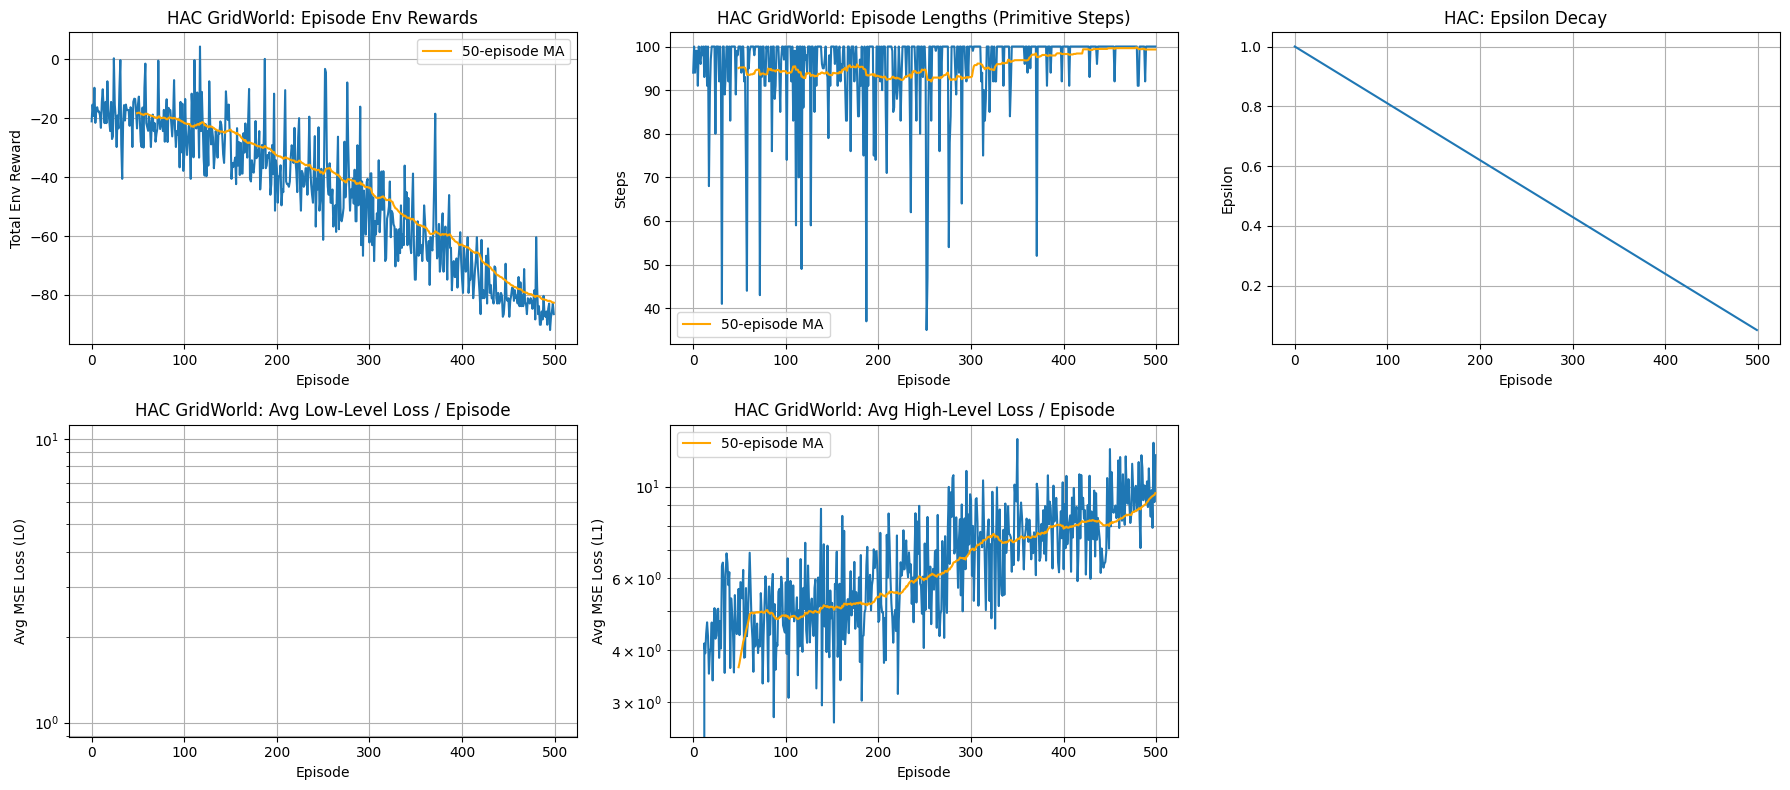

In [13]:
# Plotting results for HAC
plt.figure(figsize=(18, 8))

# Episode Rewards (Environment Reward)
plt.subplot(2, 3, 1)
plt.plot(hac_episode_rewards)
plt.title('HAC GridWorld: Episode Env Rewards')
plt.xlabel('Episode')
plt.ylabel('Total Env Reward')
plt.grid(True)
if len(hac_episode_rewards) >= 50:
    rewards_ma_hac = np.convolve(hac_episode_rewards, np.ones(50)/50, mode='valid')
    plt.plot(np.arange(len(rewards_ma_hac)) + 49, rewards_ma_hac, label='50-episode MA', color='orange')
    plt.legend()

# Episode Lengths (Primitive Steps)
plt.subplot(2, 3, 2)
plt.plot(hac_episode_lengths)
plt.title('HAC GridWorld: Episode Lengths (Primitive Steps)')
plt.xlabel('Episode')
plt.ylabel('Steps')
plt.grid(True)
if len(hac_episode_lengths) >= 50:
    lengths_ma_hac = np.convolve(hac_episode_lengths, np.ones(50)/50, mode='valid')
    plt.plot(np.arange(len(lengths_ma_hac)) + 49, lengths_ma_hac, label='50-episode MA', color='orange')
    plt.legend()

# Epsilon
plt.subplot(2, 3, 3)
plt.plot(hac_episode_epsilons)
plt.title('HAC: Epsilon Decay')
plt.xlabel('Episode')
plt.ylabel('Epsilon')
plt.grid(True)

# Low Level Loss
plt.subplot(2, 3, 4)
plt.plot(hac_low_level_losses)
plt.title('HAC GridWorld: Avg Low-Level Loss / Episode')
plt.xlabel('Episode')
plt.ylabel('Avg MSE Loss (L0)')
plt.yscale('log')
plt.grid(True, which='both')
if len(hac_low_level_losses) >= 50:
    ll_loss_ma = np.convolve(hac_low_level_losses, np.ones(50)/50, mode='valid')
    valid_indices = np.where(ll_loss_ma > 1e-8)[0]
    if len(valid_indices) > 0:
        plt.plot(np.arange(len(ll_loss_ma))[valid_indices] + 49, ll_loss_ma[valid_indices], label='50-episode MA', color='orange')
        plt.legend()

# High Level Loss
plt.subplot(2, 3, 5)
plt.plot(hac_high_level_losses)
plt.title('HAC GridWorld: Avg High-Level Loss / Episode')
plt.xlabel('Episode')
plt.ylabel('Avg MSE Loss (L1)')
plt.yscale('log')
plt.grid(True, which='both')
if len(hac_high_level_losses) >= 50:
    hl_loss_ma = np.convolve(hac_high_level_losses, np.ones(50)/50, mode='valid')
    valid_indices = np.where(hl_loss_ma > 1e-8)[0]
    if len(valid_indices) > 0:
        plt.plot(np.arange(len(hl_loss_ma))[valid_indices] + 49, hl_loss_ma[valid_indices], label='50-episode MA', color='orange')
        plt.legend()

plt.tight_layout()
plt.show()

**Analysis of HAC Learning Curves:**

1.  **Environment Rewards & Lengths:** These reflect the overall task success. Expect rewards to increase and lengths to decrease as both levels learn. Learning might be slower initially compared to simpler methods due to the complexity but should eventually solve longer-horizon problems more effectively.
2.  **Level Losses:** The losses for both low-level ($L_0$) and high-level ($L_1$) Q-networks should decrease, indicating that they are learning their respective goal-conditioned value functions from the (potentially hindsight-relabeled) transitions.
3.  **Epsilon Decay:** Standard decay.

The key indicator is whether the agent successfully learns to use subgoals to reach the final goal more efficiently than a flat agent would, especially if the task were made more complex (larger grid, sparse rewards).

# Analyzing the Learned Policies (Testing)

Test the agent by running the hierarchical policy stack.

In [14]:
def test_hac_agent(agent: HACAgent, 
                   env_instance: GridEnvironmentHAC, 
                   num_episodes: int = 5, 
                   seed_offset: int = 7000) -> None:
    """ Tests the trained HAC agent. """
    print(f"\n--- Testing HAC Agent ({num_episodes} episodes) ---")
    all_episode_rewards = []
    all_episode_lengths = []

    # Set epsilon low for testing (greedy policies at both levels)
    original_epsilon = agent.current_epsilon
    agent.current_epsilon = 0.01 # Small epsilon for minimal exploration

    for i in range(num_episodes):
        initial_state_raw = env_instance.reset()
        current_state_norm = env_instance.get_normalized_state()
        
        episode_env_reward = 0.0
        total_primitive_steps = 0
        agent.total_steps = 0 # Reset internal counter if used
        
        # Run the top level (which recursively calls lower levels)
        _, ep_env_r, _, final_state = agent.run_level(
            level=1, 
            initial_state_norm=current_state_norm,
            goal_norm=agent.final_goal_norm
        )
        
        episode_env_reward = ep_env_r
        # Need a way to get total primitive steps from run_level or track externally
        # For now, let's assume the agent class tracks it or we approximate
        total_primitive_steps = agent.total_steps # Assuming agent tracks this

        print(f"Test Episode {i+1}: Reward = {episode_env_reward:.2f}, Length = {total_primitive_steps}")
        all_episode_rewards.append(episode_env_reward)
        all_episode_lengths.append(total_primitive_steps)

    # Restore original epsilon
    agent.current_epsilon = original_epsilon
    print(f"--- Testing Complete. Average Reward: {np.mean(all_episode_rewards):.2f}, Avg Length: {np.mean(all_episode_lengths):.1f} ---")

# Run test episodes
test_hac_agent(hac_agent, hac_env_run, num_episodes=5)


--- Testing HAC Agent (5 episodes) ---
Test Episode 1: Reward = -91.90, Length = 100
Test Episode 2: Reward = -91.00, Length = 100
Test Episode 3: Reward = -91.90, Length = 100
Test Episode 4: Reward = -91.90, Length = 100
Test Episode 5: Reward = -91.90, Length = 100
--- Testing Complete. Average Reward: -91.72, Avg Length: 100.0 ---


## Common Challenges and Extensions of HAC

**Challenge: Goal Representation**
*   **Problem:** Defining effective subgoals (actions for higher levels) is crucial but non-trivial. Using absolute states (like grid cells) can be limiting.
*   **Solutions**:
    *   **Relative Goals:** Define goals as desired *changes* in state.
    *   **Learned Goal Spaces:** Learn an appropriate embedding space for goals.

**Challenge: Subgoal Feasibility & Non-Stationarity**
*   **Problem:** The high level might set subgoals that the low level cannot currently achieve, wasting time. Also, as the low level learns, the high level's task (selecting good subgoals) changes (non-stationarity).
*   **Solutions**:
    *   **Goal Filtering:** High level only proposes goals deemed achievable by the low level (e.g., based on value estimates).
    *   **Coordinated Training:** Careful scheduling of updates between levels.

**Challenge: Time Limit ($H$) Tuning**
*   **Problem:** Setting the right time limit $H$ is difficult. Too short, and subgoals are rarely achieved; too long, and learning becomes slow and less hierarchical.
   **Solutions**:
    *   **Adaptive $H$:** Try to learn or adapt $H$ based on task complexity or success rates.
    *   **Remove Fixed Limit:** Some HRL methods use termination conditions other than fixed time limits.

**Challenge: Complexity & Hyperparameters**
*   **Problem:** HRL methods like HAC introduce many new design choices and hyperparameters (number of levels, goal space, intrinsic rewards, time limits, hindsight strategy) on top of the base RL algorithm's parameters.
   **Solution:** Careful implementation, systematic tuning, starting with settings from literature.

**Challenge: Hindsight Implementation Details**
*   **Problem:** Correctly implementing the storage and sampling of hindsight goals (final vs. future strategies, how rewards/dones are set for hindsight transitions) is critical and can be subtle.
   **Solution:** Follow standard HER/HAC practices carefully.

**Extensions:**
- **HIRO:** Uses relative goals.
- **RIG:** Learns goal representations.
- **Feudal Networks:** Earlier HRL approach with manager/worker structure.

## Conclusion

Hierarchical Actor-Critic (HAC) provides a framework for tackling complex, long-horizon reinforcement learning tasks by introducing multiple levels of control. Higher levels set goals (subgoals) for lower levels, which in turn execute actions to achieve them. Key mechanisms like goal-conditioning, fixed time limits per level, intrinsic rewards for subgoal achievement, and hindsight goal relabeling enable learning in challenging scenarios, particularly those with sparse rewards.

While significantly more complex to implement and tune than flat RL algorithms, HAC and other HRL methods offer a promising direction for improving exploration, sample efficiency, and the ability to solve problems requiring reasoning over extended time scales. The core idea of decomposing tasks and learning goal-conditioned policies remains a central theme in advanced reinforcement learning research.